In [1]:
import jax
from jax import numpy as jnp

import numpy as np

from flax import linen as nn
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt

/Users/medo/Documents/Projects/jax-tutorial/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data inspection

In [2]:
ds, info = tfds.load(name="mnist", batch_size=-1, data_dir='.', as_supervised=False, with_info=True)
# as_supervised=True gives us the (image, label) as a tuple instead of a dictionary

In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='./mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [4]:
mnist_data = tfds.as_numpy(ds) # Don't run this for large datasets!

In [5]:
# Full train set
train_data = mnist_data['train']
train_images, train_labels = train_data['image'], train_data['label']
train_images = train_images.reshape(-1, 28, 28)

# # Full test set
# test_data = mnist_data['test']
# test_images, test_labels = test_data['image'], test_data['label']
# test_images = test_images.reshape(-1, 28, 28)

In [6]:
train_images.shape # shape = (60000, 28, 28)

(60000, 28, 28)

1

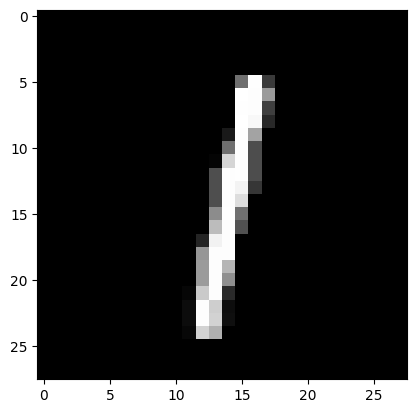

In [8]:
i = np.random.randint(0, train_images.shape[0])

plt.imshow(train_images[i], cmap='gray')
train_labels[i]

# Network definition

Linear or Dense = $A x + b$

2 layer MLP (NN): $A_2 \sigma(A_1 x + b_1) + b_2$

Output: A probability distribution over 10 outcomes $\rightarrow$ <i> Softmax</i>:

$$ S(x) = \frac{e^{x_i}}{\sum _j e^{x_j}} \qquad \Rightarrow \qquad \ln S(x) = x_i - \ln \sum _j e^{x_j}$$

In [21]:
class MLP(nn.Module):

    def setup(self):
        
        # Define the layers
        self.linear1 = nn.Dense(features=256)
        self.linear2 = nn.Dense(features=256)
        self.linear3 = nn.Dense(features=10) # 10 classes we want to predict!

    def __call__(self, x):

        h = self.linear1(x)
        h = jax.nn.sigmoid(h)
        h = self.linear2(h)
        h = jax.nn.sigmoid(h)
        h = self.linear3(h)
        
        return jax.nn.log_softmax(h)

In [22]:
# x = np.linspace(-8, 8, 100)
# y = jax.nn.sigmoid(x)
# plt.plot(x, y, c='steelblue')

In [102]:
example_input = train_images[0].reshape(-1)
example_input.shape

(784,)

In [103]:
key = jax.random.PRNGKey(0)

f = MLP()
params = f.init(key, example_input)

In [104]:
# params

In [105]:
params['params']['linear1']['kernel'].shape

(784, 256)

In [106]:
outputs = f.apply(params, example_input)
jnp.exp(outputs).sum()

Array(0.99999994, dtype=float32)

In [107]:
train_images[:32].shape

(32, 28, 28)

In [108]:
batched_data = train_images[:32]
jnp.shape(batched_data)

(32, 28, 28)

In [109]:
f.apply(params, batched_data.reshape(-1, 28**2)).shape

(32, 10)

In [110]:
predictions = f.apply(params, batched_data.reshape(-1, 28**2))

In [111]:
predictions.shape

(32, 10)

In [112]:
predictions.sum(axis=1)

Array([-24.830105, -25.364803, -24.496176, -24.95129 , -24.847576,
       -24.705235, -24.909628, -24.905033, -25.018301, -24.90951 ,
       -24.769005, -24.50695 , -24.560177, -24.998657, -24.875933,
       -24.69549 , -24.906822, -24.346184, -24.401451, -25.132065,
       -24.620852, -24.866426, -24.76841 , -24.472925, -24.597727,
       -24.50308 , -24.637085, -24.681305, -24.818832, -24.741459,
       -24.668053, -24.723787], dtype=float32)

In [113]:
def cost(predictions, targets):
    per_example_costs = -jnp.sum(targets * predictions, axis=1)
    return jnp.mean(per_example_costs)

In [114]:
def cost_for_batch(params, images, labels):

    flat_images = images.reshape(-1, 28**2)
    predictions = f.apply(params, flat_images)

    target_distribution = jax.nn.one_hot(labels, 10)

    return cost(predictions, target_distribution)

value_and_grad_cost = jax.value_and_grad(cost_for_batch)

$$ \theta ' = \theta - \eta \frac{\partial C}{\partial \theta}$$

In [115]:
example_batch = train_images[:32]
example_labels = train_labels[:32]

In [116]:
v, g = value_and_grad_cost(params, batched_data, example_labels)

In [117]:
from jax.tree_util import tree_map
import optax # Has a lot of optimizers and utilities

In [118]:
@jax.jit
def training_step(params, images, labels, lr=0.01):
    cost_val, grads = value_and_grad_cost(params, images, labels)
    new_params = tree_map(lambda p, g: p - lr * g, params, grads)
    return new_params, cost_val

In [119]:
ds = tfds.load('mnist', split='train', batch_size=32, as_supervised=True, shuffle_files=True)

In [120]:
n_epochs = 50

In [121]:
costs = []

for n in range(n_epochs):

    for example in ds:
        images, labels = tfds.as_numpy(example)
        params, cost_val = training_step(params, images, labels)

    costs.append(cost_val.item())
    print(f"Epoch {n} cost: {cost_val.item():.3f}")

Epoch 0 cost: 0.451
Epoch 1 cost: 0.255
Epoch 2 cost: 0.236
Epoch 3 cost: 0.176
Epoch 4 cost: 0.157
Epoch 5 cost: 0.187
Epoch 6 cost: 0.149
Epoch 7 cost: 0.119
Epoch 8 cost: 0.104
Epoch 9 cost: 0.126
Epoch 10 cost: 0.106
Epoch 11 cost: 0.125
Epoch 12 cost: 0.092
Epoch 13 cost: 0.122
Epoch 14 cost: 0.124
Epoch 15 cost: 0.092
Epoch 16 cost: 0.086
Epoch 17 cost: 0.076
Epoch 18 cost: 0.105
Epoch 19 cost: 0.075
Epoch 20 cost: 0.144
Epoch 21 cost: 0.105
Epoch 22 cost: 0.073
Epoch 23 cost: 0.106
Epoch 24 cost: 0.061
Epoch 25 cost: 0.109
Epoch 26 cost: 0.092
Epoch 27 cost: 0.064
Epoch 28 cost: 0.096
Epoch 29 cost: 0.060
Epoch 30 cost: 0.069
Epoch 31 cost: 0.059
Epoch 32 cost: 0.086
Epoch 33 cost: 0.091
Epoch 34 cost: 0.055
Epoch 35 cost: 0.085
Epoch 36 cost: 0.085
Epoch 37 cost: 0.050
Epoch 38 cost: 0.048
Epoch 39 cost: 0.052
Epoch 40 cost: 0.033
Epoch 41 cost: 0.074
Epoch 42 cost: 0.070
Epoch 43 cost: 0.053
Epoch 44 cost: 0.062
Epoch 45 cost: 0.094
Epoch 46 cost: 0.055
Epoch 47 cost: 0.041
Ep

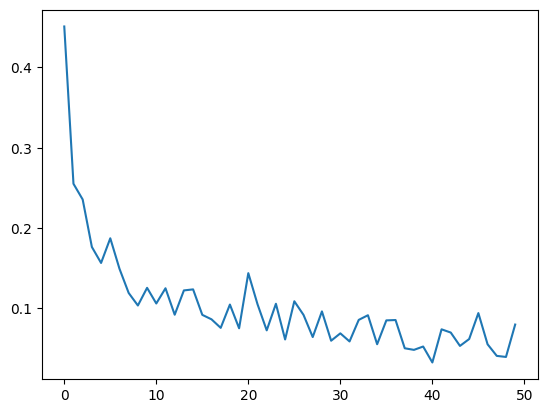

In [122]:
plt.plot(costs)

Array(5, dtype=int32)

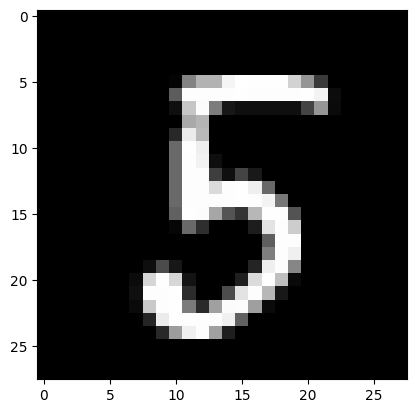

In [128]:
i = np.random.randint(0, train_images.shape[0])

plt.imshow(train_images[i], cmap='gray')
f.apply(params, train_images[i].reshape(-1, 28**2)).argmax()